# 📽 Movies Just Right For You

<br>

- Dataset: [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/)

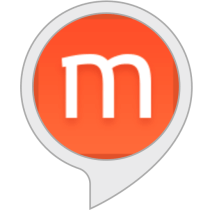

In [78]:
# import some libraries
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Load

In [79]:
# rating data load
rating_file_path = os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E9_recommendation_system/data/ml-1m/ratings.dat'

ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding='ISO-8859-1')

original_data_size = len(ratings)
original_data_size

1000209

In [80]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [81]:
# movie data load
movie_file_path=os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E9_recommendation_system/data/ml-1m/movies.dat'

cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')

movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Data Exploration & Preprocessing

In [82]:
ratings.shape

(1000209, 4)

In [83]:
rating_count = ratings.groupby('rating')['user_id'].count()

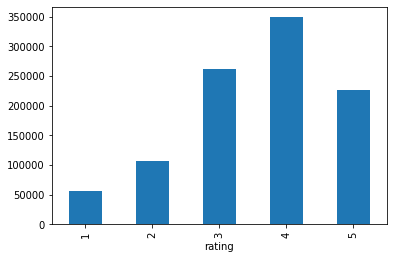

In [84]:
rating_count.plot(kind='bar')

plt.show()

In [85]:
# eliminate under rating 3
ratings = ratings[ratings['rating'] >= 3]
filtered_data_size = len(ratings)

print(f'original_data_size: {original_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / original_data_size:.2%}')

original_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


### - Check Missing Values

In [86]:
ratings.isna().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

In [87]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [88]:
ratings.shape

(836478, 4)

In [89]:
movies.shape

(3883, 3)

### - Merge Data

In [90]:
total = pd.merge(ratings, movies, how='inner', on='movie_id')
total.shape

(836478, 6)

In [91]:
total.head()

,user_id,movie_id,rating,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


In [92]:
total.isna().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
title        0
genre        0
dtype: int64

In [93]:
# user들이 가장 많이 본 영화 TOP 30
movie_count = total.groupby('title')['user_id'].count()

movie_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

In [94]:
# 총 평점이 가장 높은 영화 TOP 30
movie_sum = total.groupby('title')['rating'].sum()

movie_sum.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   14449
Star Wars: Episode IV - A New Hope (1977)                13178
Star Wars: Episode V - The Empire Strikes Back (1980)    12648
Saving Private Ryan (1998)                               11348
Star Wars: Episode VI - Return of the Jedi (1983)        11303
Raiders of the Lost Ark (1981)                           11179
Silence of the Lambs, The (1991)                         11096
Matrix, The (1999)                                       10903
Sixth Sense, The (1999)                                  10703
Terminator 2: Judgment Day (1991)                        10513
Fargo (1996)                                             10465
Schindler's List (1993)                                  10317
Braveheart (1995)                                        10125
Shawshank Redemption, The (1994)                         10085
Back to the Future (1985)                                10081
Godfather, The (1972)                            

### - Index Columns

In [95]:
user_unique = total['user_id'].unique()
movie_unique = total['movie_id'].unique()

user_to_idx = {v:k for k, v in enumerate(user_unique)}
movie_to_idx = {v:k for k, v in enumerate(movie_unique)}

In [96]:
temp_user_data = total['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(total):
    print('user_id indexing: DONE')
    total['user_id'] = temp_user_data
else:
    print('user_id indexing: Failed')
    
temp_movie_data = total['movie_id'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(total):
    print('movie_id indexing: DONE')
    total['movie_id'] = temp_movie_data
else:
    print('movie_id indexing: Failed')

user_id indexing: DONE
movie_id indexing: DONE


In [97]:
total.sort_values(by=['user_id', 'movie_id'], axis=0, inplace=True)

In [98]:
total.tail(10)

,user_id,movie_id,rating,timestamp,title,genre
599615,6037,1087,5,971809371,Hellraiser (1987),Horror
633800,6037,1194,4,971809127,Fatal Attraction (1987),Thriller
672064,6037,1358,3,971809236,"Birds, The (1963)",Horror
718135,6037,1596,5,971809283,"Nightmare on Elm Street, A (1984)",Horror
718913,6037,1602,5,971809350,Freddy's Dead: The Final Nightmare (1991),Horror
719313,6037,1608,5,971809350,Wes Craven's New Nightmare (1994),Horror
743849,6037,1782,3,971809283,Fright Night (1985),Comedy|Horror
786372,6037,2158,3,971809127,Plan 9 from Outer Space (1958),Horror|Sci-Fi
836273,6037,3512,3,971809127,City of the Living Dead (Paura nella città dei...,Horror
828959,6038,2947,3,965013156,Airport 1975 (1974),Drama


### - Drop Unnecessary Columns

In [99]:
final = total.drop(['timestamp', 'genre'], axis=1)

final.head(10)

,user_id,movie_id,rating,title
0,0,0,5,One Flew Over the Cuckoo's Nest (1975)
1680,0,1,3,James and the Giant Peach (1996)
2123,0,2,3,My Fair Lady (1964)
2734,0,3,4,Erin Brockovich (2000)
3957,0,4,5,"Bug's Life, A (1998)"
5556,0,5,3,"Princess Bride, The (1987)"
7808,0,6,5,Ben-Hur (1959)
8474,0,7,5,"Christmas Story, A (1983)"
9764,0,8,4,Snow White and the Seven Dwarfs (1937)
10471,0,9,4,"Wizard of Oz, The (1939)"


### - Movie Index Dictionary

In [100]:
dicts = final.drop(['rating', 'user_id'], axis=1)
movies_dict = dicts.set_index('title').T.to_dict('list')

movies_dict

{"One Flew Over the Cuckoo's Nest (1975)": [0],
 'James and the Giant Peach (1996)': [1],
 'My Fair Lady (1964)': [2],
 'Erin Brockovich (2000)': [3],
 "Bug's Life, A (1998)": [4],
 'Princess Bride, The (1987)': [5],
 'Ben-Hur (1959)': [6],
 'Christmas Story, A (1983)': [7],
 'Snow White and the Seven Dwarfs (1937)': [8],
 'Wizard of Oz, The (1939)': [9],
 'Beauty and the Beast (1991)': [10],
 'Gigi (1958)': [11],
 'Miracle on 34th Street (1947)': [12],
 "Ferris Bueller's Day Off (1986)": [13],
 'Sound of Music, The (1965)': [14],
 'Airplane! (1980)': [15],
 'Tarzan (1999)': [16],
 'Bambi (1942)': [17],
 'Awakenings (1990)': [18],
 'Big (1988)': [19],
 'Pleasantville (1998)': [20],
 'Wallace & Gromit: The Best of Aardman Animation (1996)': [21],
 'Back to the Future (1985)': [22],
 "Schindler's List (1993)": [23],
 'Meet Joe Black (1998)': [24],
 'Pocahontas (1995)': [25],
 'E.T. the Extra-Terrestrial (1982)': [26],
 'Titanic (1997)': [27],
 'Ponette (1996)': [28],
 'Close Shave, A (19

In [123]:
idx_dict = dicts.set_index('movie_id').T.to_dict('list')

idx_dict

{0: ["One Flew Over the Cuckoo's Nest (1975)"],
 1: ['James and the Giant Peach (1996)'],
 2: ['My Fair Lady (1964)'],
 3: ['Erin Brockovich (2000)'],
 4: ["Bug's Life, A (1998)"],
 5: ['Princess Bride, The (1987)'],
 6: ['Ben-Hur (1959)'],
 7: ['Christmas Story, A (1983)'],
 8: ['Snow White and the Seven Dwarfs (1937)'],
 9: ['Wizard of Oz, The (1939)'],
 10: ['Beauty and the Beast (1991)'],
 11: ['Gigi (1958)'],
 12: ['Miracle on 34th Street (1947)'],
 13: ["Ferris Bueller's Day Off (1986)"],
 14: ['Sound of Music, The (1965)'],
 15: ['Airplane! (1980)'],
 16: ['Tarzan (1999)'],
 17: ['Bambi (1942)'],
 18: ['Awakenings (1990)'],
 19: ['Big (1988)'],
 20: ['Pleasantville (1998)'],
 21: ['Wallace & Gromit: The Best of Aardman Animation (1996)'],
 22: ['Back to the Future (1985)'],
 23: ["Schindler's List (1993)"],
 24: ['Meet Joe Black (1998)'],
 25: ['Pocahontas (1995)'],
 26: ['E.T. the Extra-Terrestrial (1982)'],
 27: ['Titanic (1997)'],
 28: ['Ponette (1996)'],
 29: ['Close Shave, 

### - Add Favorite Movies

In [101]:
last_idx = final['user_id'].unique()[-1]

last_idx

6038

In [102]:
my_favorite = ['Men in Black (1997)', "Schindler's List (1993)", "Titanic (1997)", "Before Sunrise (1995)", "Nightmare Before Christmas, The (1993)", "Mask, The (1994)", 'Truman Show, The (1998)', 'Alice in Wonderland (1951)', 'Notting Hill (1999)', 'Pretty Woman (1990)']
my_idx = [movies_dict[m][0] for m in my_favorite]

print(my_idx)

[175, 23, 27, 213, 284, 458, 385, 619, 1151, 336]


In [103]:
my_playlist = pd.DataFrame({'user_id': [last_idx+1]*10, 'movie_id': my_idx, 'rating': [5]*10, 'title': my_favorite})

# last_idx == 6038이면 추가
if not final.isin({'user_id': [6039]})['user_id'].any():
    final = final.append(my_playlist)

In [104]:
final.tail(15)

,user_id,movie_id,rating,title
719313,6037,1608,5,Wes Craven's New Nightmare (1994)
743849,6037,1782,3,Fright Night (1985)
786372,6037,2158,3,Plan 9 from Outer Space (1958)
836273,6037,3512,3,City of the Living Dead (Paura nella città dei...
828959,6038,2947,3,Airport 1975 (1974)
0,6039,175,5,Men in Black (1997)
1,6039,23,5,Schindler's List (1993)
2,6039,27,5,Titanic (1997)
3,6039,213,5,Before Sunrise (1995)
4,6039,284,5,"Nightmare Before Christmas, The (1993)"


## CSR Matrix

In [105]:
final.reset_index(drop=True, inplace=True)

In [106]:
final['user_id'].nunique()

6040

In [107]:
final['movie_id'].nunique()

3628

In [108]:
num_user = final['user_id'].nunique()
num_movie = final['movie_id'].nunique()

csr_data = csr_matrix((final.rating, (final.user_id, final.movie_id)), shape=(num_user, num_movie))

In [109]:
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.longlong'>'
	with 836488 stored elements in Compressed Sparse Row format>

## ALS(Alternating Least Squares) Model

In [110]:
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [111]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=20, dtype=np.float32)

In [112]:
# als 모델은 input으로 item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836488 stored elements in Compressed Sparse Column format>

In [113]:
# train model
als_model.fit(csr_data_transpose)

  0%|          | 0/20 [00:00<?, ?it/s]

## Predictions

In [114]:
# 훈련된 모델이 만든 나의 벡터와 영화 벡터 구하기
zoey, titanic = final['user_id'].unique()[-1], movies_dict['Titanic (1997)'][0]
zoey_vector, titanic_vector = als_model.user_factors[zoey], als_model.item_factors[titanic]

In [115]:
zoey_vector

array([-0.26164478, -0.712401  ,  0.9916767 , -1.6715007 ,  0.38949907,
       -0.03252685, -0.43413284, -0.27310818,  0.294454  ,  0.20688565,
       -0.45553714, -0.00314768, -0.34371975, -0.4187194 ,  0.68139285,
        0.751664  , -0.85981953, -0.34476963,  0.13048977,  0.5464946 ,
       -0.8980072 ,  0.24785781,  0.26107126,  0.26790696,  0.9085229 ,
       -0.4597688 , -0.77819157, -1.2719566 , -0.33220482, -1.193341  ,
        0.08981943,  0.14404686,  0.6004396 ,  1.5702323 ,  0.7176732 ,
       -0.4411206 , -0.8118853 ,  0.6722896 , -0.19176187,  0.5339483 ,
       -0.00745661,  0.25782478, -0.21074748,  0.03592221, -0.66543794,
       -0.52825004,  0.26645628,  0.797272  ,  0.48944318,  0.3960126 ,
       -0.4432577 ,  0.43615544,  1.0262384 , -0.18699543, -0.5229149 ,
        0.59670615,  0.2505352 , -0.12718074,  0.22583535,  0.6608377 ,
       -0.60258687,  0.19856247,  0.509237  ,  0.12187532,  0.06809152,
       -0.36156598,  0.3061231 ,  0.40818515, -0.4335244 , -0.11

In [116]:
titanic_vector

array([ 5.9042349e-03, -1.6030302e-02,  6.2046256e-03, -2.8557418e-02,
        4.0363412e-02, -6.1506522e-03,  3.2514907e-02,  2.1767400e-02,
        7.4384841e-03,  8.1882272e-03,  7.1749097e-04, -1.1690247e-02,
       -1.1729763e-02,  1.1334172e-03,  4.0121317e-02,  3.9839684e-03,
       -3.2573067e-02, -2.8846139e-02, -9.0740593e-03,  4.3923803e-02,
        2.3024742e-02, -5.5835987e-03,  2.2009021e-02, -4.1168038e-02,
        5.7717193e-02, -4.7211930e-02, -5.2562384e-03, -1.6357269e-02,
       -3.4386162e-03, -5.4624245e-05,  4.9423493e-02,  3.6269553e-02,
        3.0602021e-02,  3.3743627e-02,  1.8076323e-02,  1.5973924e-02,
       -2.3077559e-02,  1.1508407e-02, -1.0954550e-02,  1.4123296e-02,
       -3.9741863e-03, -9.1332523e-04, -4.9028613e-02, -8.5698590e-03,
        1.1695049e-03,  1.7907690e-02,  3.3713382e-02,  1.3266151e-02,
        3.0020187e-02, -1.6237604e-03,  2.5309546e-02, -2.0269087e-02,
        1.9197036e-02,  4.4892267e-03,  3.6307324e-02,  2.7283642e-02,
      

In [117]:
np.dot(zoey_vector, titanic_vector)

0.66808116

In [118]:
black = movies_dict['Men in Black (1997)'][0]

black_vector = als_model.item_factors[black]
np.dot(zoey_vector, black_vector)

0.5104988

In [119]:
apollo = movies_dict['Apollo 13 (1995)'][0]

apollo_vector = als_model.item_factors[apollo]
np.dot(zoey_vector, apollo_vector)

0.17983212

In [120]:
mask = movies_dict['Mask, The (1994)'][0]

mask_vector = als_model.item_factors[mask]
np.dot(zoey_vector, mask_vector)

0.42765048

## Suggest Similar Movies

In [130]:
def get_similar_movie(favorite_movie):
    fav_movie_id = movies_dict[favorite_movie][0]
    similar_movie = als_model.similar_items(fav_movie_id, N=11)
    
    result = []
    for movie in similar_movie[1:]:
        result.append((idx_dict[movie[0]][0], movie[1]))
        
    return result

In [131]:
favorite_movie = 'Pretty Woman (1990)'

get_similar_movie(favorite_movie)

[('Sleepless in Seattle (1993)', 0.8735837),
 ("My Best Friend's Wedding (1997)", 0.83372736),
 ('Ghost (1990)', 0.78536266),
 ("You've Got Mail (1998)", 0.7686303),
 ('Notting Hill (1999)', 0.74506974),
 ('While You Were Sleeping (1995)', 0.7447429),
 ('Truth About Cats & Dogs, The (1996)', 0.7014245),
 ('Sabrina (1995)', 0.6504552),
 ('Four Weddings and a Funeral (1994)', 0.64570016),
 ('Tin Cup (1996)', 0.6439382)]

In [132]:
favorite_movie = 'Alice in Wonderland (1951)'

get_similar_movie(favorite_movie)

[('Sleeping Beauty (1959)', 0.84232235),
 ('Cinderella (1950)', 0.82501495),
 ('Dumbo (1941)', 0.8107878),
 ('Peter Pan (1953)', 0.78186965),
 ('Snow White and the Seven Dwarfs (1937)', 0.7516641),
 ('Pinocchio (1940)', 0.72975457),
 ('Sword in the Stone, The (1963)', 0.6893205),
 ('101 Dalmatians (1961)', 0.6865034),
 ('Bambi (1942)', 0.68148535),
 ('Three Caballeros, The (1945)', 0.67513454)]

## Recommender

In [134]:
user_idx = final['user_id'].unique()[-1]

recommend = als_model.recommend(user_idx, csr_data, N=20, filter_already_liked_items=True)

for r in recommend:
    print(f"You may like {idx_dict[r[0]][0]} with {r[1] * 100: .2f}%")

You may like Forrest Gump (1994) with  44.37%
You may like Jurassic Park (1993) with  44.34%
You may like Sleepless in Seattle (1993) with  38.58%
You may like You've Got Mail (1998) with  36.79%
You may like Jerry Maguire (1996) with  36.27%
You may like Edward Scissorhands (1990) with  36.14%
You may like Ghost (1990) with  34.63%
You may like My Best Friend's Wedding (1997) with  33.72%
You may like Four Weddings and a Funeral (1994) with  33.59%
You may like Lion King, The (1994) with  32.59%
You may like As Good As It Gets (1997) with  31.83%
You may like League of Their Own, A (1992) with  31.82%
You may like Aladdin (1992) with  30.22%
You may like Shawshank Redemption, The (1994) with  29.09%
You may like While You Were Sleeping (1995) with  28.79%
You may like Silence of the Lambs, The (1991) with  28.40%
You may like Little Mermaid, The (1989) with  27.85%
You may like Terminator 2: Judgment Day (1991) with  27.49%
You may like Good Will Hunting (1997) with  26.98%
You may li

In [136]:
gump = movies_dict['Forrest Gump (1994)'][0]

explain = als_model.explain(user_idx, csr_data, itemid=gump)

[(idx_dict[e[0]][0], e[1]) for e in explain[1]]

[('Pretty Woman (1990)', 0.14893666184349247),
 ("Schindler's List (1993)", 0.10445759562447021),
 ('Titanic (1997)', 0.08724494547563433),
 ('Notting Hill (1999)', 0.06354364479822211),
 ('Mask, The (1994)', 0.035613454585057776),
 ('Truman Show, The (1998)', 0.017283887461875237),
 ('Nightmare Before Christmas, The (1993)', 0.007610792363998557),
 ('Men in Black (1997)', 0.006636613039909156),
 ('Before Sunrise (1995)', -0.00470765791408383),
 ('Alice in Wonderland (1951)', -0.02837953598122951)]

## Conclusion

- Not Bad! :)